**Image Segmentation using Depth Estimation**
---


In [1]:
#SIFT Function only runs in specific versions of OpenCV

!pip install opencv-python==3.4.2.17 

!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.7 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 17.1 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [8]:
img1t = cv.imread('/content/drive/MyDrive/image_L.jpg')
img2t = cv.imread('/content/drive/MyDrive/image_R.jpg')
img1 = img1t[:,:,0]
img2 = img2t[:,:,0]
w = img1.shape[1]
h = img1.shape[0]

**Finding Matching Points through built-in SIFT Algorithm**

---
Through the SIFT algorithm, matching points will be found and will be used for finding the Fundamental Matrix.


In [9]:
sift = cv.xfeatures2d.SIFT_create() 
#Finding the corresponding points
pos1, point1 = sift.detectAndCompute(img1,None)
pos2, point2 = sift.detectAndCompute(img2,None)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
bf = cv.BFMatcher()
matches = bf.knnMatch(point1,point2,k=2)
pts1 = []
pts2 = []
#Selecting the appropriate points
for m,n in matches:
    if m.distance < 0.75*n.distance:
        pts2.append(pos2[m.trainIdx].pt)
        pts1.append(pos1[m.queryIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

Functon to draw lines on an image

In [10]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

**Epipolar Lines**

---
Through the matching points and the Fundamental Matrix, Epipolar lines will be found and plotted, through a built-in function


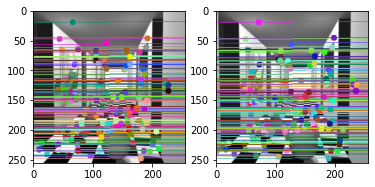

In [11]:
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 1,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

Warping the image through homographies such that if the epipolar lines are not striaght horizontal lines on the image, the image gets transformed such that they are, so that it is easier to trace through the lines

In [ ]:
#Should NOT be used if the epipolar lines are horizontal straight lines, else the image gets turned into an empty image
_, H1, H2 = cv.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=(w, h)) #Finding appropriate homographies
img1 = cv.warpPerspective(img1, H1, (w, h))
img2 = cv.warpPerspective(img2, H2, (w, h))
plt.imshow(img1)

**Disparity and Depth Maps**

---
Using the epipolar lines, we find disparities between the two images, by taking a block of values from one image and tracing along the corresponding epipolar line anf then finding where the sum of squared differences is at the lowest.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


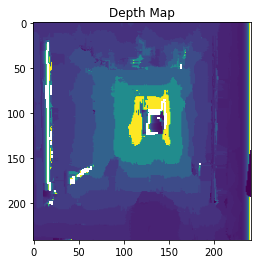

In [12]:
disparity = np.zeros((h-15,w-15))
min_index = (0,0)
B = 1; #Minimum distance from the camera
f = 1; #Focal Length
Window_size = 15 #Size of the block that we are going to use
Search_Area = 40; #Size of the area around the block that we are going to search corresponsing points from
for x in range(0,w-Window_size):
  for y in range(0,h-Window_size):
    min_ssd = 100000
    block1 = img1[y:y+Window_size,x:x+Window_size]
    for x1 in range(max(0,x-Search_Area),min(x+Search_Area,w-15)):
      block2 = img2[y:y+Window_size,x1:x1+Window_size]
      ssd = np.sum((block1-block2)**2) #Sum of Squared Differences
      if ssd < min_ssd:
        min_ssd = ssd
        min_index = x1
    disparity[y][x] = abs(min_index-x)
plt.title('Depth Map')
depth = B*f/disparity
plt.imshow(depth) #The depth is propotional to the inverse of disparity

**Making a Space of Features of Pixels**

---
Making a four-dimensional space, in which pixels will be scattered. The dimensions are:

1.   Estimated Depth
2.   Red Value
3.   Green Value
4.   Blue Value

In [78]:
image_features = np.array([10*depth[0,0],0.1*img1t[0,0,0],0.1*img1t[0,0,1],0.1*img1t[0,0,2]])
for i in range(1,w-15): 
  for j in range(1,h-15): 
    image_features = np.append(image_features, [[10*depth[j,i], 0.1*img1t[j,i,0],0.1*img1t[j,i,1],0.1*img1t[j,i,2]]])
image_features = image_features.reshape((-1,4))

**k-means for Clustering**

---
We have clustered the points, taking k=4.

In [79]:
image_features[image_features > 500] = 500
kmeans = KMeans(n_clusters=4, random_state=0).fit(image_features)

In [80]:
Segmented_Image = kmeans.labels_[1:]
Segmented_Image = Segmented_Image.reshape((h-16,w-16))

**Plotting the Segmented Image**

---
We plot the segmented image. This segmentation is indeed far from perfect, however, we can see how it has segmented the areas of the image based on the depth and colour, and how it has somewhat clearly discriminated the cone and the sphere in the image.

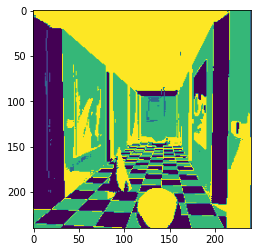

In [81]:
plt.imshow(np.transpose(Segmented_Image))

**Comparison**

---
We take the regular five dimensional space of pixels, to compare our segmentation of the image to the usual method. The dimensions are


1.   y-location
2.   x-location
3.   Red Value
4.   Green Value
5.   Blue Value



In [61]:
image_features1 = np.array([0,0,img1t[0,0,0],img1t[0,0,1],img1t[0,0,2]]) 
for i in range(1,w-15): 
  for j in range(1,h-15): 
    image_features1 = np.append(image_features1, [[j,i,img1t[j,i,0],img1t[j,i,1],img1t[j,i,2]]])
image_features1 = image_features1.reshape((-1,5))

In [62]:
image_features1[image_features1 > 500] = 500
kmeans = KMeans(n_clusters=4, random_state=0).fit(image_features1)
Segmented_Image1 = kmeans.labels_[1:]
Segmented_Image1 = Segmented_Image1.reshape((240,240))

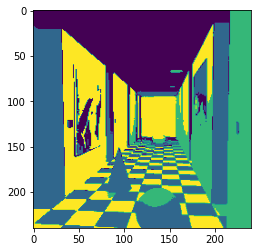

In [63]:
plt.imshow(np.transpose(Segmented_Image1))

**Conclusion**

---
The latter segmentation may give a clearer result, however, it has some problems not seen in the pervious segmentation. The cone and the sphere, here, are not much distinguished from the tiles in the image, whereas, in our segmentation, they were. Moreover our segmentation was not free from faults either. While not having clear borders, it also gave the ceiling the same cluster as the objects on the ground, persumably because we did not include the x and y locations and that the colour was the same. Hence, our segmentation is not good at finding objects themselves, but good at finding the matching colour and texture of objects.